In [2]:
import numpy as np
from skimage import io,color
import cv2 as cv
from scipy.signal import convolve2d
from matplotlib import pyplot as plt

In [3]:
def make_correction(channel:np.ndarray,mu:float)->np.ndarray:
    channel=channel/255.0
    channel_mean=channel.mean()
    channel_var=channel.var()
    channel_max=channel_mean+mu*channel_var
    channel_min=channel_mean-mu*channel_var
    channel_corrected=255.0*(channel-channel_min)/(channel_max-channel_min)
    channel_corrected=np.clip(channel_corrected,0,255)
    return channel_corrected.astype(np.uint8)

In [4]:
def shrink(x:np.ndarray,eps:float)->float:
    norm=np.linalg.norm(x,ord=2)
    if norm ==0:
        return np.zeros(shape=x.shape)
    ans=x*np.max(np.abs(x)-eps,0)/norm
    return ans

In [5]:
def get_corrected_image(img:np.ndarray,mu:float)->np.ndarray:
    R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
    R_corrected,G_corrected,B_corrected=make_correction(R,mu),make_correction(G,mu),make_correction(B,mu)
    corrected_image=np.stack([R_corrected,G_corrected,B_corrected],axis=-1)
    return corrected_image


In [6]:
def RGB2LAB(img:np.ndarray)->tuple[np.ndarray]:
    lab_img=color.rgb2lab(img)
    L,A,B=lab_img[:,:,0],lab_img[:,:,1],lab_img[:,:,2]
    return (L,A,B)

In [7]:
def initialize_RI(L_channel:np.ndarray,sigma:float=2)->tuple[np.ndarray]:
    height,width=L_channel.shape[0],L_channel.shape[1]
    R=np.zeros(shape=(height,width))
    I0=cv.GaussianBlur(L_channel,(0,0),sigmaX=sigma,sigmaY=sigma)
    return (R,I0)

In [8]:
SOBEL_KERNEL_X=np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
SOBEL_KERNEL_Y=np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])

In [9]:
def gradient_x(img:np.ndarray)->np.ndarray:
    sobel_x=np.abs(convolve2d(img,SOBEL_KERNEL_X,mode='same'))
    return np.uint8(sobel_x)

In [10]:
def gradient_y(img:np.ndarray)->np.ndarray:
    sobel_y=np.abs(convolve2d(img,SOBEL_KERNEL_Y,mode='same'))
    return np.uint8(sobel_y)

In [11]:
# delta denotes lambda in original paper we can not use lambda as variable because it is a reserved keyword in python language
def optimizer(R:np.ndarray,I:np.ndarray,I0:np.ndarray,L:np.ndarray,d:np.ndarray,alpha:float=100,beta:float=0.1,gamma:float=1,delta:float=10)->float:
    penalty1=(np.linalg.norm(R*I-L,ord=2))**2
    penalty2=(alpha*(np.linalg.norm(np.vstack((gradient_x(I),gradient_y(I))),ord=2))**2)
    penalty3=(delta*(np.linalg.norm(np.vstack((gradient_x(R),gradient_y(R)))-d,ord=2))**2)
    penalty3=beta*(penalty3+np.linalg.norm(d,ord=1))
    penalty4=gamma*(np.linalg.norm(I-I0,ord=2))**2
    return (penalty1+penalty2+penalty3+penalty4)

In [12]:
def update_d(R:np.ndarray,delta:float=10)->np.ndarray:
    d_x=shrink(gradient_x(R),1.0/2*delta)
    d_y=shrink(gradient_y(R),1.0/2*delta)
    return np.vstack((d_x,d_y))

In [13]:
def denom(D_x:np.ndarray=SOBEL_KERNEL_X,D_y:np.ndarray=SOBEL_KERNEL_Y)->np.ndarray:
    fft_d_x=np.fft.fft(D_x)
    conjugate_fft_d_x=np.conjugate(fft_d_x)
    fft_d_y=np.fft.fft(D_y)
    conjugate_fft_d_y=np.conjugate(fft_d_y)
    return fft_d_x*conjugate_fft_d_x+fft_d_y*conjugate_fft_d_y

In [14]:
def update_R(L:np.ndarray,I:np.ndarray,beta:float=0.1,delta:float=10)->np.ndarray:
    numerator=(1+beta*delta)*np.fft.fft(L/I)
    denominator=(np.fft.fft(np.eye(3,3))+beta*delta*denom())
    r=convolve2d(numerator,1/denominator,mode='same')
    inverse_fourier=np.fft.ifft(r).real
    maxi=np.max(inverse_fourier)
    return inverse_fourier/maxi 
    

In [15]:
def update_I(I0:np.ndarray,L:np.ndarray,R:np.ndarray,alpha:float=100,gamma:float=1)->np.ndarray:
    numerator=np.fft.fft(gamma*I0+L/R)
    denominator=(np.fft.fft(np.eye(3,3)+gamma)+alpha*denom())
    r=convolve2d(numerator,1/denominator,mode='same')
    return np.fft.ifft(r).real

In [16]:
def enhance_R(R:np.ndarray)->np.ndarray:
    clahe=cv.createCLAHE(clipLimit=2,tileGridSize=(8,8))
    clahe_result=clahe.apply(R)
    return clahe_result

In [17]:
image=io.imread("../images/d_r_144_.jpg")

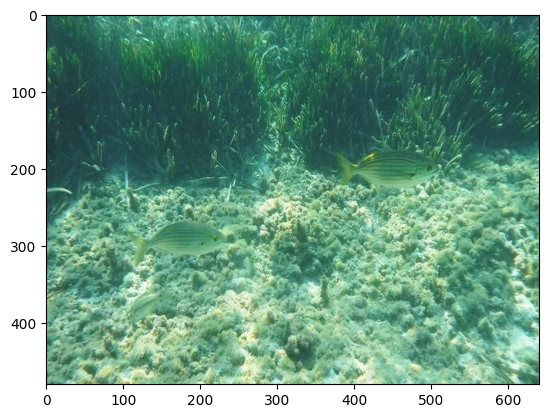

In [18]:
plt.imshow(image)
plt.show()

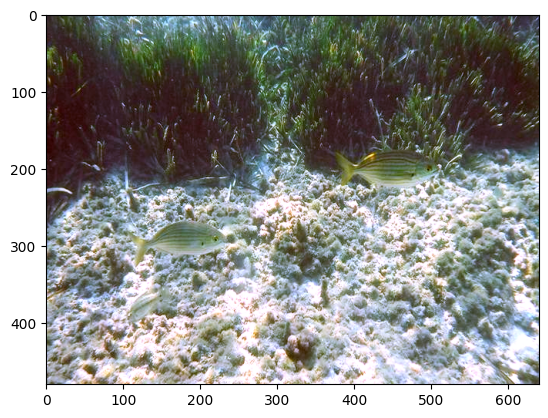

In [19]:
corrected_image=get_corrected_image(image,9)
plt.imshow(corrected_image)
plt.show()

In [20]:
L,A,B=RGB2LAB(corrected_image)

In [21]:
R,I=initialize_RI(L)

In [22]:
Io=I.copy()

In [23]:
d=update_d(R)
s

In [24]:
for i in range(5):
    print(f" loss= {optimizer(R,I,Io,L,d)}")
    # if L.any()>=I.any():
    #     break
    d=update_d(R)
    R=update_R(L,I)
    I=update_I(Io,L,R)


 loss= 11482533478.881805
 loss= 175110109060875.75


C:\Users\rahim\AppData\Local\Temp\ipykernel_22672\2923869842.py:3: RuntimeWarning: invalid value encountered in cast
  return np.uint8(sobel_x)


 loss= 1.7541329188888714e+22
 loss= 9.995860623818892e+22
 loss= 1.7182722676084926e+23


In [25]:
R

array([[ 3.66420354e-06,  3.40367467e-06,  3.31393337e-06, ...,
         1.18676404e-06,  2.29599902e-06,  2.09247843e-06],
       [ 7.89457501e-06,  7.86177534e-06,  7.74524021e-06, ...,
         5.74788886e-06,  7.36570038e-06,  6.89893407e-06],
       [-2.62739272e-06, -2.50175146e-06, -2.84692608e-06, ...,
        -3.64754862e-06, -1.50260764e-06, -2.31914392e-06],
       ...,
       [-1.34129345e-05, -1.00893645e-05, -2.21759237e-05, ...,
        -1.66909168e-05, -1.50254822e-05, -1.32329043e-05],
       [-1.52449508e-07,  8.34060464e-06,  6.97486976e-06, ...,
        -1.00597615e-05, -5.52394219e-06, -6.90982264e-07],
       [-2.05944727e-05, -1.81159709e-05, -2.42101213e-05, ...,
        -2.23552401e-05, -2.00997686e-05, -1.76537830e-05]])

In [26]:
I


array([[ -2753951.12162918,  -2798226.21811077,  -2864477.70674242, ...,
          1467157.19177843,   -845331.05933357,   -915795.93690942],
       [ 12351081.85071195,  12265480.40622354,  12251603.9438558 , ...,
         12965368.9202063 ,  12579062.78775968,  12733378.64346986],
       [  -787203.11452236,   -568968.15299022,   -118603.10028043, ...,
          -385422.06542969,  -1995813.81970735,  -1333786.11161641],
       ...,
       [  2157931.56460543,   3580329.18892638,   4315464.51827216, ...,
          4494063.54459656,   4374416.0235625 ,   3979658.43947786],
       [-82870044.12188655,   1658439.34151506,   2296554.49436076, ...,
          -837794.16135027,  -1606566.44127392, -13392233.10883299],
       [ -4350996.70245536,  -2615751.92089633,  -2405639.22875349, ...,
         -2174089.85026897,  -2255382.51649555,  -2589668.9867285 ]])